In [1]:
import pandas as pd
import numpy as np
import os
import io
import tensorflow as tf
from tensorflow.python.client import device_lib

In [4]:
NetBIOS = pd.read_csv('./01-12/DrDoS_NetBIOS.csv', low_memory=False, nrows=50000)
DNS = pd.read_csv('./01-12/DrDoS_DNS.csv', low_memory=False, nrows=50000)
LDAP = pd.read_csv('./01-12/DrDoS_LDAP.csv', low_memory=False, nrows=50000)
Portmap =  pd.read_csv('./03-11/Portmap.csv', low_memory=False, nrows=50000)

In [5]:
SNMP = pd.read_csv('./01-12/DrDoS_SNMP.csv', low_memory=False, nrows=50000)
SSDP = pd.read_csv('./01-12/DrDoS_SSDP.csv', low_memory=False, nrows=50000)
UDP = pd.read_csv('./01-12/DrDoS_UDP.csv', low_memory=False, nrows=50000)
SYN = pd.read_csv('./01-12/Syn.csv', low_memory=False, nrows=50000)

In [6]:
MSSQL = pd.read_csv('./01-12/DrDoS_MSSQL.csv', low_memory=False, nrows=50000)
NTP = pd.read_csv('./01-12/DrDoS_NTP.csv', low_memory=False, nrows=50000)
TFTP = pd.read_csv('./01-12/TFTP.csv', low_memory=False, nrows=50000)
UDPLag = pd.read_csv('./01-12/UDPLag.csv', low_memory=False, nrows=50000)

In [7]:
reflective_atacks = pd.concat([NetBIOS, DNS, LDAP, Portmap, MSSQL, NTP, SNMP, SSDP, UDP, SYN, TFTP, UDPLag])

In [8]:
# Rename the types of attacks
old_labels = ['DrDoS_SSDP', 'DrDoS_LDAP', 'DrDoS_SNMP', 'DrDoS_NetBIOS', 'DrDoS_MSSQL', 'DrDoS_UDP', 'DrDoS_DNS', 'DrDoS_NTP']
new_labels = ['SSDP', 'LDAP', 'SNMP', 'NetBIOS', 'MSSQL', 'UDP', 'DNS', 'NTP']
reflective_atacks[' Label'].replace(old_labels, new_labels, inplace=True)

In [9]:
# Drop NaN values
print('There are {} columns and {} rows in the Layer 1 Data.'.format(len(reflective_atacks.columns), len(reflective_atacks)))
reflective_atacks.dropna(axis='index', inplace=True)
reflective_atacks = reflective_atacks[~reflective_atacks.isin([np.nan, np.inf, -np.inf]).any(1)]
print('After dropping NaN values, there are {} columns and {} rows in Layer 1 Data.\n\n'.format(len(reflective_atacks.columns), len(reflective_atacks)))

There are 88 columns and 600000 rows in the Layer 1 Data.
After dropping NaN values, there are 88 columns and 579017 rows in Layer 1 Data.




In [10]:
# Remove overfitting columns (the same ones used in the original paper)
overfitting_columns = ['Unnamed: 0', ' Source IP', ' Destination IP', ' Source Port', ' Destination Port', ' Timestamp', 'SimillarHTTP', 'Flow ID']
reflective_atacks.drop(labels=overfitting_columns, axis='columns', inplace=True)
pd.set_option('display.max_columns', None)


In [11]:
print('After dropping overfitting columns: \n\t there are {} columns and {} rows'.format(len(reflective_atacks.columns), len(reflective_atacks)))

After dropping overfitting columns: 
	 there are 80 columns and 579017 rows


In [12]:
# Remove columns with only values of 0
useless_columns = [' Bwd PSH Flags', ' Fwd URG Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Bwd URG Flags', 'FIN Flag Count', ' PSH Flag Count', ' ECE Flag Count', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
reflective_atacks.drop(labels=useless_columns, axis='columns', inplace=True)
print('After dropping columns with only 0 values: \n\t there are {} columns and {} rows'.format(len(reflective_atacks.columns), len(reflective_atacks)))

After dropping columns with only 0 values: 
	 there are 68 columns and 579017 rows


In [13]:
reflective_atacks[' Label'].value_counts()

SSDP       49762
SNMP       49395
UDP        49035
MSSQL      48931
LDAP       48766
UDP-lag    48001
NetBIOS    46777
DNS        46492
Syn        45722
TFTP       44791
Portmap    42596
NTP        37375
BENIGN     21232
WebDDoS      142
Name:  Label, dtype: int64

In [14]:
# One hot encoding
reflective_atacks = pd.concat([reflective_atacks,pd.get_dummies(reflective_atacks[' Label'])],axis=1)
reflective_atacks.drop([' Label'], axis=1, inplace=True)

In [15]:
reflective_atacks.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,SYN Flag Count,RST Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,BENIGN,DNS,LDAP,MSSQL,NTP,NetBIOS,Portmap,SNMP,SSDP,Syn,TFTP,UDP,UDP-lag,WebDDoS
0,17,1,2,0,884.0,0.0,442.0,442.0,442.0,0.0,0.0,0.0,0.0,0.0,8.840000e+08,2000000.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,-2,0,2000000.0,0.0,442.0,442.0,442.0,0.0,0.0,0,0,0,0,0,0.0,663.0,442.0,0.0,-2,2,884,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,17,1,2,0,2346.0,0.0,1173.0,1173.0,1173.0,0.0,0.0,0.0,0.0,0.0,2.346000e+09,2000000.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,-2,0,2000000.0,0.0,1173.0,1173.0,1173.0,0.0,0.0,0,0,0,0,0,0.0,1759.5,1173.0,0.0,-2,2,2346,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,17,1,2,0,942.0,0.0,471.0,471.0,471.0,0.0,0.0,0.0,0.0,0.0,9.420000e+08,2000000.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,-2,0,2000000.0,0.0,471.0,471.0,471.0,0.0,0.0,0,0,0,0,0,0.0,706.5,471.0,0.0,-2,2,942,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,17,1,2,0,1020.0,0.0,510.0,510.0,510.0,0.0,0.0,0.0,0.0,0.0,1.020000e+09,2000000.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,-2,0,2000000.0,0.0,510.0,510.0,510.0,0.0,0.0,0,0,0,0,0,0.0,765.0,510.0,0.0,-2,2,1020,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,17,2,2,0,1002.0,0.0,501.0,501.0,501.0,0.0,0.0,0.0,0.0,0.0,5.010000e+08,1000000.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,-2,0,1000000.0,0.0,501.0,501.0,501.0,0.0,0.0,0,0,0,0,0,0.0,751.5,501.0,0.0,-2,2,1002,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [16]:
# Save new data to a csv file
reflective_atacks.to_csv('cleaned_up_data.csv', index=False)

In [2]:
reflective_atacks = pd.read_csv('cleaned_up_data.csv')

In [3]:
# Feature Selection
from sklearn.preprocessing import MinMaxScaler
# Import chi2 function 
from sklearn.feature_selection import chi2
label_start = 67

In [4]:
# Split into features (X) and target (Y)
reflective_X = reflective_atacks.iloc[:, :label_start]
reflective_Y = reflective_atacks.iloc[:, label_start:]

In [6]:
# Normalize all the values χ2 doesn't work with negative values
scaler = MinMaxScaler()
reflective_X = pd.DataFrame( 
    scaler.fit_transform(reflective_X), 
    columns=reflective_X.columns 
)

In [6]:
chi_scores = chi2(reflective_X , reflective_Y)

# Retrieve the P-Scores for each feature
p_vals = pd.Series(chi_scores[1],index = reflective_X.columns)

# Sort by lower to higher p-values 
p_vals.sort_values(ascending=True, inplace=True)




In [10]:
print("\t\t p-values")
#Print all p-values in ascending order based on p-value, if they are >0.5, then mark them as red
red='\033[31m'
white='\033[1;37m'
for i in range(len(p_vals)):
    str1 = "{}{:<38} = {}".format(white, p_vals.index[i], float(p_vals[i]))
    if float(p_vals[i]) > 0.5:
        str1 = "{}{:<38} = {}".format(red, p_vals.index[i], float(p_vals[i]))
    print("{} ".format(str1))

		 p-values
 Protocol                              = 0.0 
 Bwd IAT Min                           = 0.0 
Fwd PSH Flags                          = 0.0 
 Idle Min                              = 0.0 
 Min Packet Length                     = 0.0 
 Max Packet Length                     = 0.0 
 Packet Length Mean                    = 0.0 
 Packet Length Std                     = 0.0 
 RST Flag Count                        = 0.0 
 ACK Flag Count                        = 0.0 
 URG Flag Count                        = 0.0 
 CWE Flag Count                        = 0.0 
 Down/Up Ratio                         = 0.0 
 Average Packet Size                   = 0.0 
 Avg Fwd Segment Size                  = 0.0 
 Avg Bwd Segment Size                  = 0.0 
 Subflow Fwd Bytes                     = 0.0 
Init_Win_bytes_forward                 = 0.0 
 Init_Win_bytes_backward               = 0.0 
Active Mean                            = 0.0 
 Active Min                            = 0.0 
Idle Mean             

In [12]:
for i in range(len(p_vals)):
    print(p_vals.index[i])

 Protocol
 Bwd IAT Min
Fwd PSH Flags
 Idle Min
 Min Packet Length
 Max Packet Length
 Packet Length Mean
 Packet Length Std
 RST Flag Count
 ACK Flag Count
 URG Flag Count
 CWE Flag Count
 Down/Up Ratio
 Average Packet Size
 Avg Fwd Segment Size
 Avg Bwd Segment Size
 Subflow Fwd Bytes
Init_Win_bytes_forward
 Init_Win_bytes_backward
Active Mean
 Active Min
Idle Mean
 Idle Std
 Idle Max
 Bwd IAT Max
 Bwd IAT Std
Fwd Packets/s
Bwd IAT Total
 Flow Duration
Total Length of Fwd Packets
 Fwd Packet Length Max
 Fwd Packet Length Min
 Fwd Packet Length Mean
 Fwd Packet Length Std
Bwd Packet Length Max
 Bwd IAT Mean
 Bwd Packet Length Mean
 Bwd Packet Length Std
Flow Bytes/s
 Flow Packets/s
 Flow IAT Mean
 Bwd Packet Length Min
 Inbound
 Flow IAT Std
 Flow IAT Max
 Fwd IAT Max
Fwd IAT Total
 Fwd IAT Mean
 Fwd IAT Std
 act_data_pkt_fwd
 SYN Flag Count
 Packet Length Variance
 Active Max
 Bwd Packets/s
 Active Std
 min_seg_size_forward
Subflow Fwd Packets
 Total Fwd Packets
 Subflow Bwd Packets
 

Text(0.5, 0, 'Correlation Coefficient')

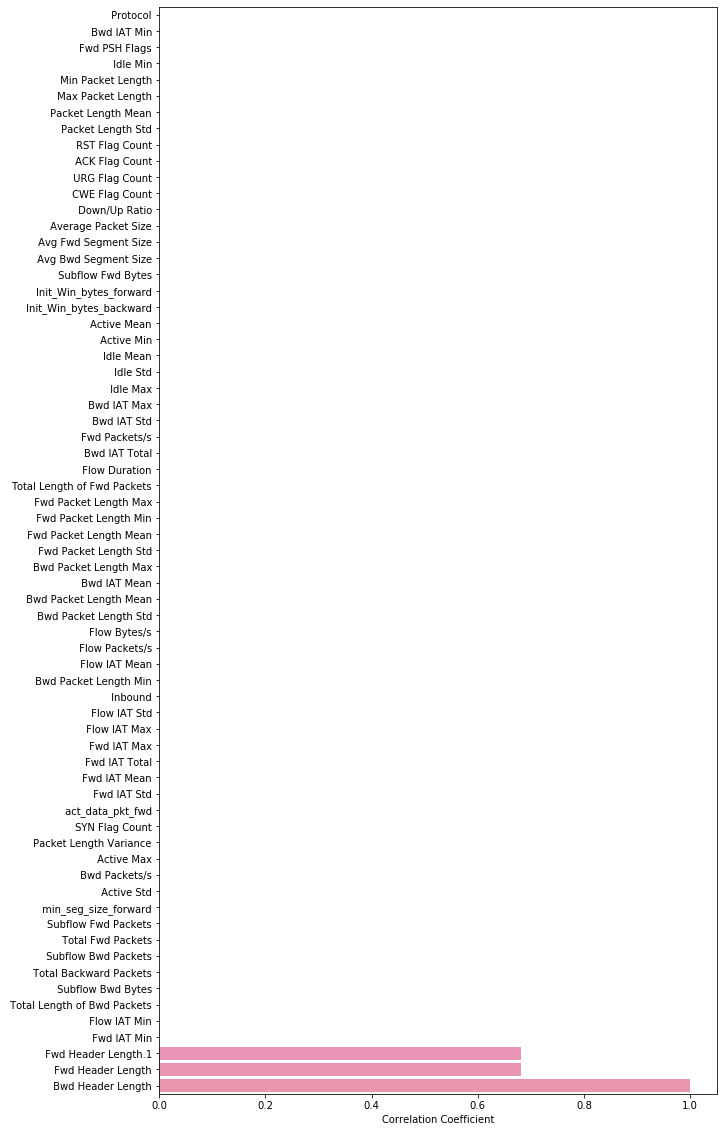

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,20))

sns.barplot(x=p_vals, y=p_vals.index)
plt.xlabel("p-value")

In [5]:
# Pearson Correlation
import pandas as pd 
from scipy.stats import pearsonr 
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
reflective_X = reflective_X.astype(np.int64)
reflective_Y = reflective_Y.astype(np.int64)

In [10]:
pd.set_option('display.max_rows', None)
print(reflective_X.dtypes)

 Protocol                       int64
 Flow Duration                  int64
 Total Fwd Packets              int64
 Total Backward Packets         int64
Total Length of Fwd Packets     int64
 Total Length of Bwd Packets    int64
 Fwd Packet Length Max          int64
 Fwd Packet Length Min          int64
 Fwd Packet Length Mean         int64
 Fwd Packet Length Std          int64
Bwd Packet Length Max           int64
 Bwd Packet Length Min          int64
 Bwd Packet Length Mean         int64
 Bwd Packet Length Std          int64
Flow Bytes/s                    int64
 Flow Packets/s                 int64
 Flow IAT Mean                  int64
 Flow IAT Std                   int64
 Flow IAT Max                   int64
 Flow IAT Min                   int64
Fwd IAT Total                   int64
 Fwd IAT Mean                   int64
 Fwd IAT Std                    int64
 Fwd IAT Max                    int64
 Fwd IAT Min                    int64
Bwd IAT Total                   int64
 Bwd IAT Mea

In [8]:
from scipy.stats import pearsonr 
pearson_res = {}
for i in reflective_X.columns:
  corr, _ = pearsonr(reflective_X[i], reflective_Y) 
  pearson_res[reflective_X[i].name] = corr

TypeError: No loop matching the specified signature and casting was found for ufunc add

In [ ]:
pearson_res = {key: val for key, val in sorted(pearson_res.items(), key = lambda ele: ele[1])}
black='\033[30m'
print("\t\t  Pearson r-values")
for (k_l1,v_l1) in zip(pears_L1_dict.items()):
   if v_l1 >= 0:
     str1 = "{}{:<38} =  {:>.5f}".format(black, k_l1, v_l1)
   else:
     str1 = "{}{:<37}  = {:>.5f}".format(black, k_l1, v_l1)
   print("{} \t {}| \t {}".format(str1, black))

In [5]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [11]:
leng=3

#reflective_X = reflective_X.to_numpy()
#reflective_Y = reflective_Y.to_numpy()


# Build Model
model = Sequential()  
model.add(LSTM(leng, input_shape=(1, leng),return_sequences=True,activation='sigmoid'))
model.add(LSTM(leng, input_shape=(1, leng),return_sequences=True,activation='sigmoid'))
model.add(LSTM(leng, input_shape=(1, leng),return_sequences=True,activation='sigmoid'))
model.add(LSTM(leng, input_shape=(1, leng),return_sequences=True,activation='sigmoid'))
model.add(LSTM(leng, input_shape=(1, leng),return_sequences=True,activation='sigmoid'))
model.add(LSTM(leng, input_shape=(1, leng),return_sequences=True,activation='sigmoid'))
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])
model.fit(reflective_X, reflective_Y, nb_epoch=100, batch_size=50,validation_data=(reflective_X,reflective_Y))


predict = model.predict(data)


/home/drake/miniconda3/envs/gpu2/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


ValueError: Error when checking input: expected lstm_19_input to have 3 dimensions, but got array with shape (579017, 67)